<a href="https://colab.research.google.com/github/msapurva/Sorting-arrays-using-Pointer_Networks_w_Fast_Weights/blob/master/Fast_Weights_based_Pointer_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from datetime import datetime as dt

In [0]:
plt.style.use('ggplot')

In [0]:
tf.enable_eager_execution()
np.random.seed(42)
tf.random.set_random_seed(42)

### Experiment Configuration

In [0]:
# Training and Dev Data
minSeqSize=2
maxSeqSize=5

# Training Data 
batchSize=32
numOfBatches=200
datasize=batchSize*numOfBatches*(maxSeqSize-minSeqSize+1)

# Dev data
devBatchSize=64
devNumBatches=10

# Test data
testBatchSize=64
testNumBatches=10


# Ptr Model Config
hidden_dimensions=200

# FW Model Config(directly modifies the class default values)
fwS=1
fwlearningrate=0.5
fwdecayrate=0.9

# For reproducing ablation on input dimension on transformation.
# A None value leads the system to use the default value of hidden_dimensions. 
# Change this to required integer to get a new value
given_fw_x_size=None



# over-fitting tolerance cut-off
# for some cases the initial batch or an intermediate batch might cross this due to random chance and not due to overfitting. 
#In such cases modify this and run the code again
overfitcutoff=0.1 

# epoch configuration defined later below. Look at epochsToRun variable to tune this

### Dataset Preparation

In [0]:
def makeData(minSeqSize,maxSeqSize,batchSize,numOfBatches):
    X={}
    Y={}
    datasize=batchSize*numOfBatches*(maxSeqSize-minSeqSize+1)

    for seqLen in range(minSeqSize,maxSeqSize+1):
        X[seqLen]=[]
        Y[seqLen]=[]

        for dataidx in range(int(datasize/(maxSeqSize-minSeqSize+1))):
            seqBase=np.random.uniform(size=(seqLen))
            aSeq=seqBase
            X[seqLen]+=[aSeq]
            aRec=[]
            for e in np.sort(seqBase):
                idx=list(seqBase).index(e)
                aRec+=[np.zeros(seqLen,dtype=np.float32)]
                aRec[-1][idx]=1
            Y[seqLen]+=[aRec]

        X[seqLen]=np.array(X[seqLen],dtype=np.float32)
        X[seqLen]=np.reshape(X[seqLen],[X[seqLen].shape[0],X[seqLen].shape[1],1])
        Y[seqLen]=np.array(Y[seqLen],dtype=np.float32)
    return X,Y

In [0]:
trainX,trainY=makeData(minSeqSize,maxSeqSize,batchSize,numOfBatches)

In [0]:
print('Train X for',minSeqSize,':',trainX[minSeqSize].shape)
print('Train Y for',minSeqSize,':',trainY[minSeqSize].shape)

Train X for 2 : (6400, 2, 1)
Train Y for 2 : (6400, 2, 2)


### Pointer Network with Fast Weights

In [0]:
class FastWeightsCell(tf.keras.Model):
    def __init__(self,features=1, output_size=1,decay_rate = fwdecayrate, learning_rate = fwlearningrate, hidden_size=50):
        super(FastWeightsCell, self).__init__()
        self.DR = decay_rate 
        self.LR = learning_rate 
        self.features=features
        self.output_size=output_size
        self.hidden_size = hidden_size 

        
        self.W_x = tf.Variable(tf.random_uniform([self.hidden_size,self.features], -np.sqrt(2/self.features), np.sqrt(2/self.features)), dtype=tf.float32)
        self.B_x = tf.Variable(tf.zeros([self.hidden_size,1]), dtype=tf.float32)
        self.W_h = tf.Variable(initial_value = 0.5 * np.identity(self.hidden_size), dtype = tf.float32)
        self.W_y = tf.Variable(tf.random_uniform([self.output_size,self.hidden_size], -np.sqrt(2/self.hidden_size), np.sqrt(2/self.hidden_size)), dtype = tf.float32)
        self.B_y = tf.Variable(tf.zeros([self.output_size,1]), dtype= tf.float32)
        self.scale = tf.Variable(tf.ones([1,self.hidden_size,1]), dtype = tf.float32) 
        self.shift = tf.Variable(tf.zeros([1,self.hidden_size,1]), dtype = tf.float32)
        
        # values of A and H matricies
        self.A = None  
        self.H = None  

    def call(self,X,H,A,S=fwS):
        X = tf.cast(X, tf.float32)
        self.H=H
        self.A=A
        self.A = tf.scalar_mul(self.DR, self.A) + tf.scalar_mul(self.LR,(tf.matmul(H, tf.transpose(H,perm=[0,2,1]))))
        broad_W_h=tf.broadcast_to(self.W_h,[self.H.shape[0].value,self.W_h.shape[0].value,self.W_h.shape[1].value])
        broad_W_x=tf.broadcast_to(self.W_x,[self.H.shape[0].value,self.W_x.shape[0].value,self.W_x.shape[1].value])
        H_s=tf.nn.relu(tf.matmul(broad_W_h,self.H)+tf.matmul(broad_W_x,X)        +     tf.expand_dims(self.B_x,0))
        for _ in range(S):
            H_s=         tf.matmul(self.A,H_s)  +    tf.matmul(broad_W_h,self.H) + tf.matmul(broad_W_x,X)  +  tf.expand_dims(self.B_x,0)                    
            # applying Layer Normalization 
            mean, var = tf.nn.moments(H_s, axes =0, keep_dims = True)
            H_s = (self.scale*(H_s - mean))/(tf.sqrt(var + 1e-5) + self.shift)           
            # applying non linearity
            H_s = tf.nn.relu(H_s)        
        self.H = H_s
        broad_W_y=tf.broadcast_to(self.W_y,[self.H.shape[0].value,self.W_y.shape[0].value,self.W_y.shape[1].value])
        output = tf.matmul(broad_W_y,self.H) + tf.expand_dims(self.B_y,0)
        # --- return output, hidden state, and value of matrix A ---
        return output, self.H, self.A

In [0]:
class FWPointerNetwork(tf.keras.Model):
    def __init__(self,features=1, output_size=None, hidden_size=50, fw_x_size=None, attentionInternalDim=None):
        super(FWPointerNetwork, self).__init__()
        self.features = features
        self.output_size=output_size
        if self.output_size is None:
            self.output_size=features
        self.hidden_size = hidden_size
        self.attentionInternalDim=attentionInternalDim
        if self.attentionInternalDim is None:
            self.attentionInternalDim=self.hidden_size
        self.fw_x_size=fw_x_size
        if self.fw_x_size is None:
            self.fw_x_size=self.hidden_size

        # Encoder and Encoder Input
        self.encodercell = FastWeightsCell(features=self.fw_x_size, output_size=self.output_size,hidden_size=self.hidden_size)
        self.W_e = tf.Variable(tf.random_uniform([self.fw_x_size, self.features], -0.08, 0.08), dtype=tf.float32)    
        self.B_e = tf.Variable(tf.random_uniform([self.fw_x_size, 1], -0.08, 0.08), dtype=tf.float32)

        # Decoder and Decoder Input
        self.decodercell = FastWeightsCell(features=self.fw_x_size, output_size=self.output_size,hidden_size=self.hidden_size)
        self.W_d = tf.Variable(tf.random_uniform([self.fw_x_size, self.features], -0.08, 0.08), dtype=tf.float32)    
        self.B_d = tf.Variable(tf.random_uniform([self.fw_x_size, 1], -0.08, 0.08), dtype=tf.float32)

        # Attention Related Vector with bias
        self.W1 = tf.Variable(tf.random_uniform([self.attentionInternalDim,self.hidden_size], -0.08, 0.08), dtype=tf.float32)
        self.W2 = tf.Variable(tf.random_uniform([self.attentionInternalDim,self.hidden_size], -0.08, 0.08), dtype=tf.float32)
        self.V = tf.Variable(tf.random_uniform([self.attentionInternalDim, 1], -0.5, 0.5), dtype=tf.float32)
        self.B_ptr = tf.Variable(tf.random_uniform([self.attentionInternalDim,1], -0.08, 0.08), dtype=tf.float32)


    def call(self, X):
        givenbatchsize=X.shape[0].value
        givenSeqLen=X.shape[1].value
        eHstates = []
        eH = tf.zeros([givenbatchsize, self.hidden_size,1],dtype=np.float32)
        eA = tf.zeros([givenbatchsize, self.hidden_size,self.hidden_size],dtype=np.float32)
        for i in range(givenSeqLen):            
            X_i = tf.transpose(X[:,i:i+1],[0,2,1])
            broad_W_e=tf.broadcast_to(self.W_e,[givenbatchsize,self.W_e.shape[0].value,self.W_e.shape[1].value])
            cell_input = tf.nn.elu(tf.matmul(broad_W_e,X_i) + tf.expand_dims(self.B_e,0))
            _, eH,        eA        = self.encodercell(cell_input, eH, eA)
            eHstates.append(eH)

        dH = eHstates[-1]
        dA = tf.zeros([givenbatchsize, self.hidden_size,self.hidden_size],dtype=np.float32)
        X_i = tf.constant(-1,dtype=np.float32,shape=[givenbatchsize,self.features,1])
        attentionVector_all=None
        outputVector_all=None
        identity=tf.eye(givenSeqLen,dtype=np.float32)
        
        for i in range(givenSeqLen):
            broad_W_d=tf.broadcast_to(self.W_d,[givenbatchsize,self.W_d.shape[0].value,self.W_d.shape[1].value])
            cell_input = tf.nn.elu(tf.matmul(broad_W_d,X_i) + tf.expand_dims(self.B_d,0))
            _, dH,        dA        = self.decodercell(cell_input, dH, dA)
            broad_W1 = tf.broadcast_to(self.W1,[givenbatchsize,self.W1.shape[0].value,self.W1.shape[1].value])            
            broad_W2 = tf.broadcast_to(self.W2,[givenbatchsize,self.W2.shape[0].value,self.W2.shape[1].value])
            broad_V = tf.broadcast_to(self.V,[givenbatchsize,self.V.shape[0].value,self.V.shape[1].value])
            d_part=tf.matmul(broad_W2,dH)            
            attentionVector_i=None
            for encoderIndex in range(givenSeqLen):
                attentionVector_component=tf.matmul(broad_W1,eHstates[encoderIndex])+ d_part     + tf.expand_dims(self.B_ptr,0)
                attentionVector_component=tf.nn.elu(attentionVector_component)
                attentionVector_component=tf.matmul(tf.transpose(broad_V,perm=[0,2,1]),attentionVector_component)
                if attentionVector_i is None:
                    attentionVector_i=attentionVector_component
                else:
                    attentionVector_i=tf.concat([attentionVector_i,attentionVector_component],axis=2)
            attentionVector_i=tf.nn.softmax(attentionVector_i,axis=2)            
            if attentionVector_all is None:
                attentionVector_all=attentionVector_i
            else:
                attentionVector_all=tf.concat(       [attentionVector_all  ,   attentionVector_i   ],axis=1)            
            predictedOutput_i  =   tf.cast(tf.argmax(attentionVector_i,axis=2),dtype=np.int32)
            extractionMatrix=tf.nn.embedding_lookup(identity,tf.reshape(predictedOutput_i,[predictedOutput_i.shape[0]]))
            extractionMatrix=tf.expand_dims(extractionMatrix,axis=1)
            X_i=tf.matmul(  tf.cast(extractionMatrix,dtype=np.float32) ,      X   )
            if outputVector_all is None:
                outputVector_all=X_i
            else:
                outputVector_all=tf.concat([outputVector_all,X_i],axis=1)
            X_i=tf.transpose(X_i,[0,2,1])
        return attentionVector_all,outputVector_all 

In [0]:
def runAndGetLoss(X,Y,model,isVerbose=0,headlimit=-1):

    attn,output=model(X)
    loss=tf.reduce_mean(tf.keras.backend.categorical_crossentropy(Y, attn))
    loss=(loss/float(maxSeqSize-minSeqSize+1))
    
    if isVerbose>0:
      for instance_idx in range(X.shape[0]):
        print("====== Actual :",np.reshape(X[instance_idx],X[instance_idx].shape[0]))
        print('  - Predicted :',np.reshape(output[instance_idx],output[instance_idx].shape[0]))
        print('\n\n')
        if headlimit!=-1 and headlimit<instance_idx:
          break    
    return attn,output,loss



### Instantiate the Network

In [0]:
fwpn = FWPointerNetwork(features=trainX[minSeqSize][0].shape[1], output_size=trainX[minSeqSize][0].shape[1], hidden_size=hidden_dimensions,fw_x_size=given_fw_x_size)

### Output of Network Before Training

In [0]:
# Use data point
seqLen=minSeqSize
attn,output,aloss=runAndGetLoss(trainX[seqLen][0:batchSize],trainY[seqLen][0:batchSize],fwpn,1)
print("loss:",aloss)
print("attn:")
print(attn)

Instructions for updating:
Colocations handled automatically by placer.
====== Actual : [0.37454012 0.9507143 ]
  - Predicted : [0.37454012 0.37454012]



====== Actual : [0.7319939 0.5986585]
  - Predicted : [0.7319939 0.7319939]



====== Actual : [0.15601864 0.15599452]
  - Predicted : [0.15601864 0.15601864]



====== Actual : [0.05808361 0.8661761 ]
  - Predicted : [0.8661761 0.8661761]



====== Actual : [0.601115  0.7080726]
  - Predicted : [0.601115 0.601115]



====== Actual : [0.02058449 0.96990985]
  - Predicted : [0.96990985 0.96990985]



====== Actual : [0.83244264 0.21233912]
  - Predicted : [0.21233912 0.21233912]



====== Actual : [0.18182497 0.1834045 ]
  - Predicted : [0.18182497 0.18182497]



====== Actual : [0.30424225 0.52475643]
  - Predicted : [0.30424225 0.30424225]



====== Actual : [0.43194503 0.29122913]
  - Predicted : [0.43194503 0.43194503]



====== Actual : [0.6118529  0.13949387]
  - Predicted : [0.6118529 0.6118529]



====== Actual : [0.29214466 0

### Dev Data Creation

In [0]:
# create dev data and batches
devX,devY=makeData(minSeqSize,maxSeqSize,devBatchSize,devNumBatches)
testX,testY=makeData(minSeqSize,maxSeqSize+1+5,testBatchSize,testNumBatches)
def getTestLoss():
  # print 1
  aloss=0
  aloss1=0
  aloss2=0

  print("SUMMARY")
  for seqLen in range(minSeqSize,maxSeqSize+1):
    X,Y=makeData(seqLen,seqLen,testBatchSize,testNumBatches)
    _,_,interdevLoss=runAndGetLoss(X[seqLen],Y[seqLen],fwpn)
    aloss=interdevLoss
    print('Seq:',seqLen,'Size:',X[seqLen].shape[0],'loss:',aloss.numpy())
    aloss1+=aloss

  print('---')

  for seqLen in range(maxSeqSize+1,maxSeqSize+1+5):
    X,Y=makeData(seqLen,seqLen,testBatchSize,testNumBatches)
    _,_,interdevLoss=runAndGetLoss(X[seqLen],Y[seqLen],fwpn)
    aloss=interdevLoss
    print('Seq:',seqLen,'Size:',X[seqLen].shape[0],'loss:',aloss.numpy())
    aloss2+=aloss

  print('loss1:',np.round(aloss1.numpy()/float(maxSeqSize-minSeqSize+1),6))
  print('loss2:',np.round(aloss2.numpy()/float(5),6))
  return aloss1,aloss2


### Model Training

##### Config Training

In [0]:
# create batches of training data
batchedDataset={}
for seqLen in range(minSeqSize,maxSeqSize+1):
    batchedDataset[seqLen]=[]
    for aBatch in tf.data.Dataset.from_tensor_slices((trainX[seqLen],trainY[seqLen])).batch(batchSize):
        batchedDataset[seqLen]+=[aBatch]

In [0]:
# training configuration
lastepoch=-1
optimizer = tf.train.AdamOptimizer()
loss_history = []
wholeLoss_history=[]
devLoss_history=[]
total_attention = []
bestwholeloss=10000000
bestdevloss=10000000
bestepoch=-1

##### Run Training

In [0]:
epochsToRun = 10
overfitFlag=False

In [0]:
starttime=dt.now()
maxEpochsforthis=lastepoch+1+epochsToRun
for epoch in range(lastepoch+1,maxEpochsforthis):
    if overfitFlag:
        break
    lastepoch=epoch
    print("New Epoch Started:",epoch)
    for batch in range(numOfBatches):
        wholeLoss=0
        for seqLen in range(minSeqSize,maxSeqSize+1):

            with tf.GradientTape() as tape:
                input_data, target_data=batchedDataset[seqLen][batch]
                _,_,batch_loss=runAndGetLoss(input_data,target_data,fwpn)
            variables = fwpn.variables
            grads = tape.gradient(batch_loss, variables)
            optimizer.apply_gradients(zip(grads, variables), global_step=tf.train.get_or_create_global_step())
            loss_history.append(batch_loss.numpy())
            wholeLoss+=batch_loss/float(maxSeqSize-minSeqSize+1)
        for seqLen in range(minSeqSize,maxSeqSize+1):
            wholeLoss_history.append(wholeLoss.numpy())
            
        if batch % 10 == 0:
            print("\tEpoch {:03d}/{:03d}: Loss at batchSetNum {:02d}: {:.9f}".format((epoch), maxEpochsforthis-1, batch, wholeLoss),np.round(((dt.now()-starttime).seconds)/60.0,1), "mins")

            devLoss=0
            
            for seqLen in range(minSeqSize,maxSeqSize+1):
                _,_,interdevLoss=runAndGetLoss(devX[seqLen],devY[seqLen],fwpn)
                devLoss+=interdevLoss/float(maxSeqSize-minSeqSize+1)

            for _ in range((maxSeqSize-minSeqSize+1)*10):
              devLoss_history.append(devLoss.numpy())
            
            print('\t               WholeLoss:',np.round(wholeLoss.numpy(),5),'DevLoss:',np.round(devLoss,5))
            
            if len(devLoss_history)==0:
              bestdevloss=devLoss
              bestwholeloss=wholeLoss
              bestepoch=lastepoch
              besttestloss1,besttestloss2=getTestLoss()
            
            if bestdevloss>min(devLoss_history):
              print(" ----------------------------------------------------------------- new best found ^.^")
              bestdevloss=devLoss
              bestwholeloss=wholeLoss
              bestepoch=lastepoch
              besttestloss1,besttestloss2=getTestLoss()
              
            if (devLoss-wholeLoss)>overfitcutoff:
              print('Stoppping due to overfit')
              overfitFlag=True
              break
    print("Epoch {:03d}/{:03d} completed \t - \tLoss at batchSetNum {:02d}: {:.9f}".format((epoch), maxEpochsforthis-1, batch, wholeLoss),np.round(((dt.now()-starttime).seconds)/60.0,1), "mins")
print("Final loss: {:.9f}".format(wholeLoss),np.round(((dt.now()-starttime).seconds)/60.0,1), "mins")
print('total epochs run so far(starts from 0):',lastepoch)

New Epoch Started: 0
	Epoch 000/009: Loss at batchSetNum 00: 0.380821794 0.0 mins
	               WholeLoss: 0.38082 DevLoss: 0.36582
 ----------------------------------------------------------------- new best found ^.^
SUMMARY
Seq: 2 Size: 640 loss: 0.21022432
Seq: 3 Size: 640 loss: 0.3325615
Seq: 4 Size: 640 loss: 0.42505035
Seq: 5 Size: 640 loss: 0.49624684
---
Seq: 6 Size: 640 loss: 0.5499851
Seq: 7 Size: 640 loss: 0.59457
Seq: 8 Size: 640 loss: 0.6330074
Seq: 9 Size: 640 loss: 0.6677626
Seq: 10 Size: 640 loss: 0.69355917
loss1: 0.366021
loss2: 0.627777
	Epoch 000/009: Loss at batchSetNum 10: 0.299850285 0.1 mins
	               WholeLoss: 0.29985 DevLoss: 0.29995
 ----------------------------------------------------------------- new best found ^.^
SUMMARY
Seq: 2 Size: 640 loss: 0.1715949
Seq: 3 Size: 640 loss: 0.27407372
Seq: 4 Size: 640 loss: 0.348507
Seq: 5 Size: 640 loss: 0.40324715
---
Seq: 6 Size: 640 loss: 0.44961694
Seq: 7 Size: 640 loss: 0.4889637
Seq: 8 Size: 640 loss: 0.

In [0]:
print('Best Dev Loss:',bestdevloss.numpy())
print('Corresponding Best Train Loss:',bestwholeloss.numpy())
print('Corresponding Best epoch:',bestepoch)

Best Dev Loss: 0.23639691
Corresponding Best Train Loss: 0.23653848
Corresponding Best epoch: 8


### Loss plot over the entire training sequence

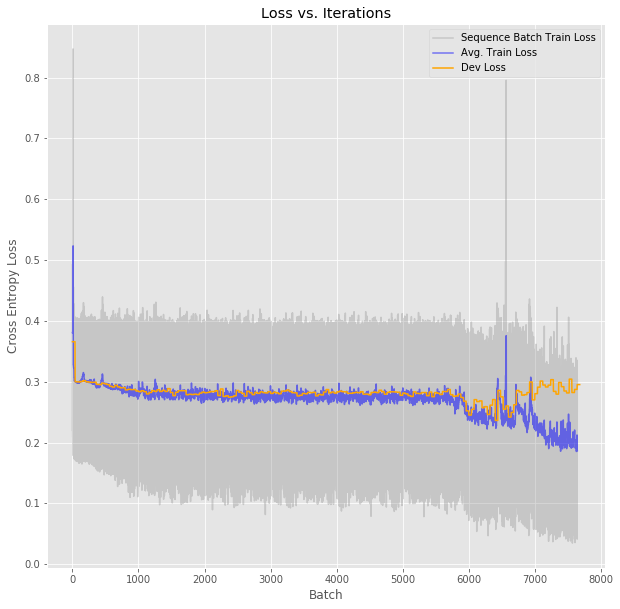

In [0]:
plt.figure(figsize=(10, 10))
plt.title("Loss vs. Iterations")
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Batch')
plt.plot(loss_history,label='Sequence Batch Train Loss',color='grey',alpha=0.3)
plt.plot(wholeLoss_history,label='Avg. Train Loss',color='blue',alpha=0.5)
plt.plot(devLoss_history,label='Dev Loss',color='orange')
plt.legend()

### Inference

In [0]:
# print 1
aloss=0
aloss1=0
aloss2=0

print("SUMMARY")
for seqLen in range(minSeqSize,maxSeqSize+1):
  X,Y=makeData(seqLen,seqLen,testBatchSize,testNumBatches)
  _,_,interdevLoss=runAndGetLoss(X[seqLen],Y[seqLen],fwpn)
  aloss=interdevLoss
  print('Seq:',seqLen,'Size:',X[seqLen].shape[0],'loss:',aloss.numpy())
  aloss1+=aloss

print('---')

for seqLen in range(maxSeqSize+1,maxSeqSize+1+5):
  X,Y=makeData(seqLen,seqLen,testBatchSize,testNumBatches)
  _,_,interdevLoss=runAndGetLoss(X[seqLen],Y[seqLen],fwpn)
  aloss=interdevLoss
  print('Seq:',seqLen,'Size:',X[seqLen].shape[0],'loss:',aloss.numpy())
  aloss2+=aloss

print('loss1:',np.round(aloss1.numpy()/float(maxSeqSize-minSeqSize+1),6))
print('loss2:',np.round(aloss2.numpy()/float(5),6))


SUMMARY
Seq: 2 Size: 640 loss: 0.051954843
Seq: 3 Size: 640 loss: 0.15676808
Seq: 4 Size: 640 loss: 0.3844819
Seq: 5 Size: 640 loss: 0.5566648
---
Seq: 6 Size: 640 loss: 0.59395415
Seq: 7 Size: 640 loss: 0.6234234
Seq: 8 Size: 640 loss: 0.6548155
Seq: 9 Size: 640 loss: 0.6718853
Seq: 10 Size: 640 loss: 0.69363725
loss1: 0.287467
loss2: 0.647543


In [0]:
# print 2
print("DETAILED")
for seqLen in range(minSeqSize,maxSeqSize+1+5):
  print()
  if seqLen==maxSeqSize+1:
      print('*********************************************************************************************************************************************')
  print()
  X,Y=makeData(seqLen,seqLen,testBatchSize,testNumBatches)
  print('Seq:',seqLen,'Size:',X[seqLen].shape[0])
  print('--------------------------------------------------------------------------------------------------------------------------------------------')
  _,_,interdevLoss=runAndGetLoss(X[seqLen],Y[seqLen],fwpn,1,5)



DETAILED


Seq: 2 Size: 640
--------------------------------------------------------------------------------------------------------------------------------------------
====== Actual : [0.83574224 0.06025785]
  - Predicted : [0.06025785 0.83574224]



====== Actual : [0.01662471 0.79840994]
  - Predicted : [0.01662471 0.79840994]



====== Actual : [0.01190267 0.30980283]
  - Predicted : [0.01190267 0.30980283]



====== Actual : [0.22009102 0.21262218]
  - Predicted : [0.21262218 0.21262218]



====== Actual : [0.218951   0.90957433]
  - Predicted : [0.218951   0.90957433]



====== Actual : [0.7722809  0.23816308]
  - Predicted : [0.23816308 0.7722809 ]



====== Actual : [0.11175715 0.17111683]
  - Predicted : [0.11175715 0.17111683]





Seq: 3 Size: 640
--------------------------------------------------------------------------------------------------------------------------------------------
====== Actual : [0.08056203 0.5001086  0.61318433]
  - Predicted : [0.08056203 0.61318433 